In [ ]:

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as nps
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [ ]:
# 데이터 로드 및 전처리
######################
# 데이터 예시: train.csv -> columns: [conversation, class]
# test.csv -> columns: [conversation]
train_df = pd.read_csv("/content/sample_data/train_data.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")

# 클래스 인코딩
labels = train_df["class"].unique().tolist()
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["class"])  # 0~4로 변환

# 클래스별 20% Validation Split
X = train_df["conversation"].values
y = train_df["label"].values
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y)
train_df_split = pd.DataFrame({"conversation": X_train, "label": y_train})
val_df_split = pd.DataFrame({"conversation": X_val, "label": y_val})

In [ ]:
# Dataset 정의
######################
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        if self.labels is not None:
            label = self.labels[idx]
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask
            }

In [ ]:
# 토크나이저 및 데이터로더
######################
model_name = "monologg/kobigbird-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = TextDataset(train_df_split["conversation"].values,
                            train_df_split["label"].values,
                            tokenizer=tokenizer, max_len=512)
val_dataset = TextDataset(val_df_split["conversation"].values,
                          val_df_split["label"].values,
                          tokenizer=tokenizer, max_len=512)
test_dataset = TextDataset(test_df["text"].values,
                           labels=None,
                           tokenizer=tokenizer, max_len=512)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/492k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/169 [00:00<?, ?B/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# 일부 레이어 Freeze 예: BERT encoder의 하위 절반 레이어 고정, 임베딩 레이더도 고정.
for name, param in model.named_parameters():
    if "embeddings" in name:
        param.requires_grad = False
    elif "encoder.layer." in name:
        layer_num = int(name.split("encoder.layer.")[1].split(".")[0])
        if layer_num < 6:
            param.requires_grad = False

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 훈련 세팅
######################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataParallel을 통해 멀티 GPU 활용
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

epochs = 3
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
total_steps = len(train_loader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(total_steps*0.1),
                                            num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
# 학습 루프
######################
train_losses = []
val_losses = []

for epoch in range(epochs):
    # --- Train ---
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1 [Val]: 100%|██████████| 588/588 [01:29<00:00,  6.59it/s]


Epoch 1: Train Loss: 0.4816, Val Loss: 0.2166


Epoch 2 [Val]: 100%|██████████| 588/588 [01:29<00:00,  6.59it/s]


Epoch 2: Train Loss: 0.1608, Val Loss: 0.1523


Epoch 3 [Val]: 100%|██████████| 588/588 [01:29<00:00,  6.59it/s]

Epoch 3: Train Loss: 0.0848, Val Loss: 0.1358


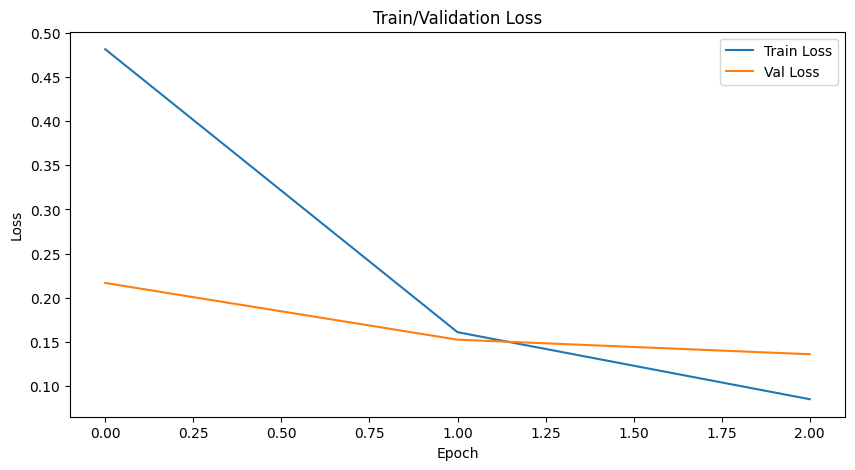

In [ ]:
# Loss 시각화
######################
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Train/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# 테스트 데이터 예측
######################
model.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Prediction"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)

# 예측 라벨 복원
pred_labels = label_encoder.inverse_transform(predictions)

# 결과 저장
test_df["pred_class"] = pred_labels
test_df.to_csv("test_predictions.csv", index=False)

Test Prediction: 100%|██████████| 125/125 [00:19<00:00,  6.57it/s]


In [ ]:
test_df['pred_class'].value_counts()

,count
pred_class,
기타 괴롭힘 대화,140
직장 내 괴롭힘 대화,121
갈취 대화,115
협박 대화,96
일반,28


In [ ]:
sub = pd.read_csv('/content/sample_data/submission.csv')

In [ ]:
sub['class'] = test_df['pred_class']

In [ ]:
sub['idx'] = sub['file_name']
sub['target'] = sub['class']
sub = sub.drop(columns=['file_name','class'])
sub = sub[['idx', 'target']]
sub['target'] = sub['target'].apply(lambda x: 0 if x == '협박 대화' else
                                                   1 if x == '갈취 대화' else
                                                   2 if x == '직장 내 괴롭힘 대화' else
                                                   3 if x == '기타 괴롭힘 대화' else
                                                   4 if x == '일반' else None)


In [ ]:
sub

,idx,target
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,4
4,t_004,3
...,...,...
495,t_495,2
496,t_496,2
497,t_497,1
498,t_498,2


In [ ]:
sub.to_csv('submission_kobigbird.csv', index=False, encoding='utf-8-sig')